In [1]:
%matplotlib inline
import sys
import os.path

sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime as d
from scipy import signal
from sklearn.linear_model import MultiTaskLasso, Ridge

import swellEx_env
from normalMode import Chinook
from beamformers import bartlet
from beamformers import wnc_bisection as wnc
import loadSIO as sio

# MF with source close to reciever

In [2]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
# tStart = 1980
# tStart = 3780
tStart = 3450


snapLength = 2
snapStep = 2
numSnaps = 23
sD = 54

wncMaxNorm = 2

frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
frequencyNumber = 0
testFreq = frequencies[frequencyNumber]
tol = 1

year = str(1996)
experimentStart = d.datetime.strptime(year + 'J1312315',\
                                      '%YJ%j%H%M')
rangeTime = experimentStart + d.timedelta(0, tStart)
sourceRange = swellEx_env.getRangeAtTime(rangeTime)

# figure output directory
figDir = '/Users/edwardlrichards/Documents/Classes/convexOptimization/figures'

In [3]:
enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray(flipArray=True)
numSensors = sensorPosition.size
# Match field boundries
# zMax = enviornment.getProfile(0.).getZatInterface()[1]
zMax = 120
rMax = 2000  # m
rMin = 500
numR = 100
numZ = 50

sD = 54

# Solver Parameters
decimation = 10
fB_width = 300

#Least squares
lamb = 1e4
alpha = 1e-1
wncMaxNorm = 2

In [4]:
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[rMin:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)
numLook = numR * numZ

In [5]:
# load data file
sampleStart = tStart * fs
numSamples = (snapLength + (snapStep * numSnaps)) * fs
channels = -1
data = sio.load_selection(dataFile, sampleStart, numSamples, channels,\
        channelNames = sensorPosition)

In [6]:
def getSnap(snapNum, frequencyNumber, tol = 1):
    snapSamples = np.int(snapLength * fs)
    stepSamples = np.int(snapStep * fs)

    NFFT = np.int(2 ** np.ceil(np.log2(2 * snapSamples)))

    loadRange = np.arange(snapSamples) + snapNum * stepSamples
    oneSnap = data['data'][loadRange, :]
    oneSnap *= np.kaiser(snapSamples, 2.5 * np.pi)[:,None]
    snapF = np.fft.fft(oneSnap, NFFT, axis = 0)
    f = (np.arange(NFFT) / NFFT) * fs
    snapIndex = (f >= (frequencies[frequencyNumber] - tol)) &\
        (f <= (frequencies[frequencyNumber] + tol))
    return snapF, f, snapIndex

In [7]:
# basic pwelch
psd = []
for i in range(numSnaps):
    snapF, f, snapIndex = getSnap(i, frequencyNumber, tol = tol)
    psd.append(np.abs(snapF) ** 2)
psd = np.array(psd)
psd = np.mean(psd, axis=0)

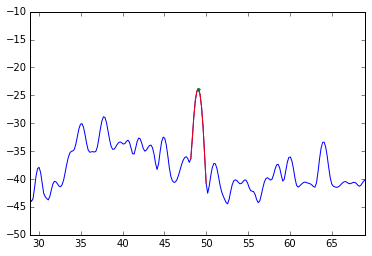

In [8]:
psd_channel = 0
plotSeries = 10 * np.log10(psd[:,psd_channel] + np.spacing(1))
_ = plt.plot(f, plotSeries)
_ = plt.plot(f[snapIndex], plotSeries[snapIndex], 'r')

_ = plt.xlim(frequencies[frequencyNumber] - 20, frequencies[frequencyNumber] + 20)
_ = plt.ylim(-50, -10)
subFreqBin = np.argmax(plotSeries[snapIndex])

_ = plt.plot(f[snapIndex][subFreqBin], plotSeries[snapIndex][subFreqBin], 'g.')

In [9]:
K = []
snapShots = []
for i in range(numSnaps):
    snapF, _, snapIndex = getSnap(i, frequencyNumber, tol = tol)
    snapShots.append([d.conj() for d in snapF[snapIndex,:]])
    K.append([np.outer(d, d.conj()) for d in snapShots[-1]])
    

K = np.array(K)[:, subFreqBin, :]
snapShots = np.array(snapShots)[:, subFreqBin, :]
K_measured = np.mean(K, axis=0)

In [10]:
# Synthetic data set
nm_model = Chinook(frequencies[frequencyNumber], enviornment)
nm_model.calculateModes_eig(fB_width, decimation)
syntheticData = nm_model.calculatePressure(sD, sensorPosition.values, sourceRange * 1e3)
K_synthetic = np.outer(syntheticData, np.conj(syntheticData))

In [11]:
# Make normalized look vectors
lookVectors = [nm_model.calculatePressure(d, zPlot, rPlot) for d in sensorPosition]
W = np.dstack(lookVectors)
W = W / np.linalg.norm(W, axis = 2)[:,:,None]
W = np.nan_to_num(W)
W = np.reshape(W, (numR * numZ, numSensors))

In [12]:
def B_DB(b):
    B = np.reshape(b, (numR, numZ))
    B = np.nan_to_num(B)
    B = 10 * np.log10(np.abs(B) + np.spacing(1))
    B = B.T
    if np.sum(B > -100) >0:
        B = B - np.max(B)
    return B

In [13]:
# setup for L1 minimization
X = W.T
numLook = X.shape[1]
XSplit = np.vstack((np.hstack((X.real, X.imag)),\
                    np.hstack((-X.imag, X.real))))

# Y = syntheticData.values
Y = snapShots
YSplit = np.hstack((np.vstack((Y.real, Y.imag)),\
                    np.vstack((-Y.imag, Y.real)))).T

In [14]:
b_bart = [np.dot(np.dot(look.conj(), K_measured), look) for look in X.T]
B_bart = B_DB(b_bart)

In [15]:
W_ls_reg = np.linalg.solve(X.conj().T.dot(X) + lamb * np.identity(numLook), X.conj().T.dot(Y.T))
B_ls_reg = np.abs(np.nan_to_num(W_ls_reg)) ** 2
B_ls_reg = np.mean(B_ls_reg, axis=1)
B_ls_reg = np.reshape(B_ls_reg, (numR, numZ))
B_ls_reg = 10 * np.log10(np.abs(np.array(B_ls_reg).T) + np.spacing(1))
B_ls_reg -= np.max(B_ls_reg)

In [16]:
alpha = 1e-2
lasso_solver = MultiTaskLasso(alpha=alpha)
W_lasso = lasso_solver.fit(XSplit, YSplit)

stack1 = W_lasso.coef_[::2,:]
stack1 = np.squeeze(stack1[:,:numLook] + 1j * stack1[:,numLook:])

stack2 = W_lasso.coef_[1::2,:]
stack2 = np.squeeze(-1j * stack2[:,:numLook] + stack2[:,numLook:])

lassoResult = np.linalg.norm(np.array((stack1, stack2)), axis = 0)
lassoResult = np.linalg.norm(lassoResult, axis = 0)
B_lasso = B_DB(lassoResult)

B_noZero = B_lasso[B_lasso > -100]
R_noZero = R_nm[B_lasso > -100]
Z_noZero = Z[B_lasso > -100]

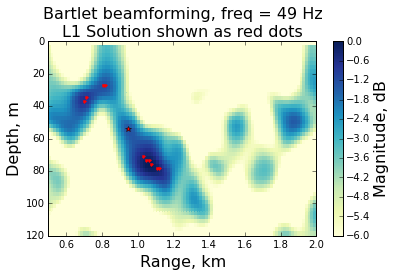

In [17]:
_ = plt.figure(2)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, B_ls_reg, cmap = plt.cm.YlGnBu)
_ = plt.clim(-6, 0)
cbar = plt.colorbar()
cbar.set_label('Magnitude, dB', fontsize=16)

for b, r, z in zip(B_noZero, R_noZero, Z_noZero):
    plt.plot(r / 1e3,z,'r.')
    
_ = plt.xlim(rMin / 1e3, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Bartlet beamforming, freq = %i Hz' %testFreq +\
             '\nL1 Solution shown as red dots', fontsize=16)
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m', fontsize=16)
_ = plt.xlabel('Range, km', fontsize=16)
plt.subplots_adjust(top=0.8)
_ = plt.savefig(os.path.join(figDir, 'mf_49Hz'))

In [18]:
b_wnc = wnc(K_measured, W, wncMaxNorm)
B_wnc = B_DB(b_wnc)

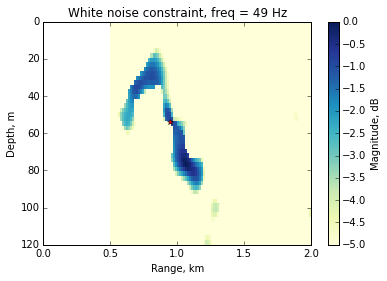

In [19]:
_ = plt.pcolormesh(R_nm / 1e3, Z, B_wnc, cmap = plt.cm.YlGnBu)
_ = plt.clim(-5, 0)
cbar = plt.colorbar()
cbar.set_label('Magnitude, dB')

_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('White noise constraint, freq = %i Hz' %testFreq)
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [20]:
numFreq = 3
XSplit = []
YSplit = []
K_measured = []
W_modeled = []
for i in range(numFreq):
    # Synthetic data set
    nm_model = Chinook(frequencies[i], enviornment)
    nm_model.calculateModes_eig(fB_width, decimation)

    # Make normalized look vectors
    lookVectors = [nm_model.calculatePressure(d, zPlot, rPlot) for d in sensorPosition]
    W = np.dstack(lookVectors)
    W = W / np.linalg.norm(W, axis = 2)[:,:,None]
    W = np.nan_to_num(W)
    W = np.reshape(W, (numR * numZ, numSensors))
    W_modeled.append(W)
    
        # basic pwelch
    psd = []
    for snap in range(numSnaps):
        snapF, f, snapIndex = getSnap(snap, i, tol = tol)
        psd.append(np.abs(snapF) ** 2)
    psd = np.array(psd)
    psd = np.mean(psd, axis=0)
    plotSeries = 10 * np.log10(psd[:,psd_channel] + np.spacing(1))
    subFreqBin = np.argmax(plotSeries[snapIndex])
    
    K = []
    snapShots = []
    for snap in range(numSnaps):
        snapF, _, snapIndex = getSnap(snap, i, tol = tol)
        snapShots.append([d.conj() for d in snapF[snapIndex,:]])
        K.append([np.outer(d, d.conj()) for d in snapShots[-1]])
    
    K = np.array(K)[:, subFreqBin, :]
    snapShots = np.array(snapShots)[:, subFreqBin, :]
    K_measured.append(np.mean(K, axis=0))

    # setup for L1 minimization
    X = W.T
    numLook = X.shape[1]
    XSplit.append(np.vstack((np.hstack((X.real, X.imag)),\
                        np.hstack((-X.imag, X.real)))))

    Y = snapShots
    YSplit.append(np.hstack((np.vstack((Y.real, Y.imag)),\
                        np.vstack((-Y.imag, Y.real)))).T)

In [21]:
X_super = np.reshape(np.array(XSplit), (numFreq * 2 * numSensors, numLook * 2))
Y_super = np.reshape(np.array(YSplit), (numFreq * 2 * numSensors, numSnaps * 2))

In [22]:
alpha = 1.2e-2
lasso_solver = MultiTaskLasso(alpha=alpha)
W_lasso = lasso_solver.fit(X_super, Y_super)

stack1 = W_lasso.coef_[::2,:]
stack1 = np.squeeze(stack1[:,:numLook] + 1j * stack1[:,numLook:])

stack2 = W_lasso.coef_[1::2,:]
stack2 = np.squeeze(-1j * stack2[:,:numLook] + stack2[:,numLook:])

lassoResult = np.linalg.norm(np.array((stack1, stack2)), axis = 0)
lassoResult = np.linalg.norm(lassoResult, axis = 0)
B_lasso = B_DB(lassoResult)

B_noZero = B_lasso[B_lasso > -100]
R_noZero = R_nm[B_lasso > -100]
Z_noZero = Z[B_lasso > -100]

In [23]:
B_bart = []
for k, w in zip(K_measured, W_modeled):
    
    b_bart = [np.dot(np.dot(look.conj(), k), look) for look in w]
    B_bart.append(B_DB(b_bart))

In [24]:
meanBart = np.mean(np.array(B_bart), axis=0)
meanBart -= np.max(meanBart)

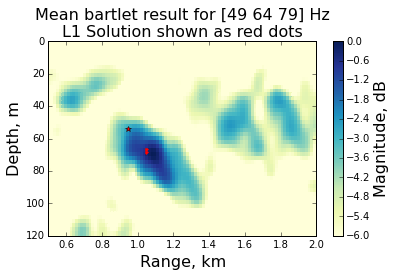

In [25]:
synFreq = np.array(frequencies)[np.arange(numFreq)]
_ = plt.figure(2)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, meanBart, cmap = plt.cm.YlGnBu)
_ = plt.clim(-6, 0)
cbar = plt.colorbar()
cbar.set_label('Magnitude, dB', fontsize=16)
for b, r, z in zip(B_noZero, R_noZero, Z_noZero):
    plt.plot(r/1e3, z, 'r.')
    
_ = plt.xlim(rMin / 1e3, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Mean bartlet result for ' + str(synFreq) + ' Hz' +\
             '\nL1 Solution shown as red dots', fontsize=16)
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m', fontsize=16)
_ = plt.xlabel('Range, km', fontsize=16)
plt.subplots_adjust(top=0.8)
_ = plt.savefig(os.path.join(figDir, 'mf_broadBand'))

In [26]:
# Plot the Gram Matrix over range
zOfInterest = np.mean(Z_noZero)

nm_model = Chinook(frequencies[numFreq], enviornment)
nm_model.calculateModes_eig(fB_width, decimation)

In [27]:
# Make normalized look vectors
lookVectors = np.array([np.squeeze(nm_model.calculatePressure(d, zOfInterest, rPlot)) for d\
                        in sensorPosition])
lookVectors = lookVectors / np.linalg.norm(lookVectors, axis = 0)[None,:]
lookVectors = np.nan_to_num(lookVectors)

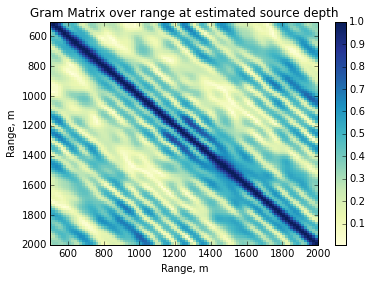

In [28]:
gram = np.abs(np.dot(lookVectors.T.conj(), lookVectors))
rRange = np.outer(rPlot, np.ones(rPlot.shape))
_ = plt.pcolormesh(rRange, rRange.T, gram, cmap=plt.cm.YlGnBu)
_ = plt.ylim(rMax, rMin)
_ = plt.xlim(rMin, rMax)
cbar = plt.colorbar()
_ = plt.title('Gram Matrix over range at estimated source depth')
_ = plt.xlabel('Range, m')
_ = plt.ylabel('Range, m')
_ = plt.savefig(os.path.join(figDir, 'mf_gram'))